Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [60]:
NAME = "yuke li"
COLLABORATORS = ""

---

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment !

# Problem description

We will solve a Regression task that is very common in Finance
- Given the return of "the market", predict the return of a particular stock

That is
- Given the return of a proxy for "the market" at time $t$, predict the return of, e.g., Apple at time $t$.

As we will explain,
being able to predict the relationship between two financial instruments opens up possibilities
- Use one instrument to "hedge" or reduce the risk of holding the other
- Create strategies whose returns are independent of "the market"
    - Hopefully make a profit regardless of whether the market goes up or down

## Goal

You will create models of increasing complexity in order to explain the return of Apple (ticker $\aapl$)
- The first model will have a single feature: return of the market proxy, ticker $\spy$
- Subsequent models will add the return of other tickers as additional features

## Learning Objectives
- Learn how to solve a Regression task
- Become facile in the `sklearn` toolkit for Machine Learning

## How to report your answers
We will mix explanation of the topic with tasks that you must complete. 

Look for 
the string "**Question**" to find a task that you must perform.

Most of the tasks will require you to create some code at the location indicated by

>`# YOUR CODE HERE
raise NotImplementedError()`

- Replace `raise NotImplementedError()` with your own code

# Standard imports

In [61]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

In [62]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1
import seaborn as sns
# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get The data


The first step in our Recipe is Get the Data.

The data are the daily prices of a number of individual equities and equity indices.

The prices are arranged in a series in ascending date order (a timeseries).
- There are many `.csv` files for equity or index in the directory `DATA_DIR`

## API for students

We will define some utility routines to help you.

In this way, you can focus on the learning objectives rather than data manipulation.

This is not representative of the "real world"; you will need to complete data manipulation tasks in later assignments.

We provide a class `HELPER`
- Instantiated as 
>    `helper = helper.HELPER()`

With methods
- `getData`:
    - Get examples for a list of equity tickers and an index ticker.
    - Called as
    > `data = helper.getData( tickers, index_ticker, attrs)`
        - `tickers` is a list of tickers
        - `index` is the ticker of the index  
        - `attrs` is a list of data attributes
   

**Question:**
- Create code to
    - Get the adjusted close price of $\aapl$ and $\spy$ 
    - Assign the result to variable `data`

**Hint:**
- Use the `getData` method from the helper class
    - The list of tickers contains just the single ticker $\aapl$
    - The index ticker is $\spy$
    - The list of attributes is the single attribute `Adj Close`


In [63]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = "Adj Close"

data=helper.getData([ticker], index_ticker, [priceAttr])

# Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek at the data you retrieved

In [64]:
data.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-01-03,110.9539,213.8428
2017-01-04,110.8297,215.1149
2017-01-05,111.3933,214.9440
2017-01-06,112.6351,215.7131
2017-01-09,113.6668,215.0010


In [65]:
# Print the Start time and End time
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03
End time:  2019-10-31


## Create DataFrame of price levels for the training examples

The training examples will be stored in a DataFrame.

- The DataFrame should have two columns: the price level for the ticker and for the index
- The minimum date in the DataFrame should be **the trading day before** `start_dt`
    - That is: the latest date for which there is data and which is less than `start_dt`
    - For example, if `start_dt` is a Monday, the "day before" would be Friday, not Sunday.
        - Similarly for the case where the day before `start_dt` is a holiday
- The maximum date in the DataFrame should be `end_dt`

The reason we are adding one day prior to `start_dt`
- We want to have returns (percent price changes) from `start_dt` onwards
- In order to compute a return for `start_dt`, we need the level from the prior day

**Question:**

- Complete the function `getRange()`
    - To return the subset of rows of our examples
    - Beginning on the **trading day before** date `start_dt`
    - Ending on date `end_dt`


In [66]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None

# Set variable train_data_price to be a DataFrame with two columns
## AAPL_Adj_Close, SPY_Adj_Close
## with dates as the index
## Having minimum date equal to THE DAY BEFORE start_dt
## Having maximum date equal to end_dt

def getRange(df, start_dt, end_dt):
    '''
    Return the the subset of rows of DataFrame df
    restricted to dates between start_dt and end_dt
    
    Parameters
    ----------
    df: DataFrame
    - The data from which we will take a subset
    
    start_dt: String
    - Start date
    
    end_dt: String
    - End date
    '''
    # YOUR CODE HERE
    df.index = pd.to_datetime(df.index)

    prior_trading_day = df.index[df.index < start_dt][-1]  

    selected_range = df.loc[prior_trading_day:end_dt]
    
    return selected_range
    #raise NotImplementedError()

train_data_price = getRange(data, start_dt, end_dt)
print(train_data_price.head())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2017-12-29        164.2589       258.2823
2018-01-02        167.1999       260.1310
2018-01-03        167.1708       261.7763
2018-01-04        167.9473       262.8796
2018-01-05        169.8594       264.6314


In [67]:
print(train_data_price.tail())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2018-09-24        216.7654       285.3496
2018-09-25        218.1399       285.0848
2018-09-26        216.4021       284.2318
2018-09-27        220.8496       285.0260
2018-09-28        221.6252       285.0555


As you can see, each row has two attributes for one  date
- Price (adjusted close) of ticker $\aapl$
- Price (adjusted close) of the market proxy $\spy$

# Create test set

We just created a set of training examples as a subset of the rows of `data`.

We will do the same to create a set of test examples.

**Question:**

Set variable `test_data_price`
- To  the subset of rows of our examples
- Beginning on the **trading day before** date `test_start_dt`
- Ending on date `test_end_dt`

**Hint**
- Use `getRange` with different arguments for the dates

In [68]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(data, test_start_dt, test_end_dt)
#raise NotImplementedError()


In [69]:
test_data_price.head()
test_data_price.tail()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-28,221.6252,285.0555
2018-10-01,223.1175,286.0458
2018-10-02,225.1006,285.8791
2018-10-03,227.8398,286.0359
2018-10-04,223.8342,283.8004


,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-12-24,144.6565,231.1158
2018-12-26,154.8435,242.7929
2018-12-27,153.8386,244.6569
2018-12-28,153.9174,244.3412
2018-12-31,155.4050,246.4814


# Prepare the data

In Finance, it is very typical to work with *relative changes* (e.g., percent price change)
rather than *absolute changes* (price change) or *levels* (prices).

Without going into too much detail
- Relative changes are more consistent over time than either absolute changes or levels
- The consistency can facilitate the use of data over a longer time period

For example, let's suppose that prices are given in units of USD (dollar)
- A price change of 1 USD is more likely for a stock with price level 100 than price level 10
    - A relative change of $1/100 = 1 %$ is more likely than a change of $1/10 = 10%$
    - So relative changes are less dependent on price level than either price changes or price levels
    
    
To compute the *return* (percent change in prices)
 for ticker $\aapl$ (Apple) on date $t$

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$


# Transformations: transform the training data

Our first task is to transform the data from price levels (Adj Close)
to Percent Price Changes.

Moreover, the date range for the training data is specified to be in the range
from `start_dt` (start date) to `end_dt`, inclusive on both sides.

**Note**

We will need to apply **identical** transformations to both the training and test data examples.

In the cells that immediately follow, we will do this only for the **training data**

You will need to repeat these steps for the test data in a subsequent step.

You are well-advised to create subroutines or functions to accomplish these tasks !
- You will apply them first to transform training data
- You will apply them a second time to transform the test data

We will achieve this is several steps

## Create DataFrame of returns for training examples

Create a new DataFrame with percent price changes of the columns, rather than the levels

**Question:**
- Complete function `getReturns()` to set variable `train_data_ret` to be a DataFrame with the same columns
    - But where the prices have been replaced by day over day percent changes
    - The column names of `train_data_ret` should be the same as the original columns names
    - We give you code to rename the columns to reflect the changed meaning of the data in the next step

**Hint:**
- look up the Pandas `pct_change()` method    

In [70]:
train_data_ret = None

def getReturns(df):
    '''
    Return the day over day percent changes of adjusted price
    
    Parameters
    ----------
    df: DataFrame
    '''
    
    # YOUR CODE HERE
    df_returns = df.pct_change().dropna()
    return df_returns
    #raise NotImplementedError()

train_data_ret = getReturns(train_data_price)
train_data_ret.head()


,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


In [71]:
train_data_ret.tail()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-24,0.014380,-0.003322
2018-09-25,0.006341,-0.000928
2018-09-26,-0.007966,-0.002992
2018-09-27,0.020552,0.002794
2018-09-28,0.003512,0.000103


Since the columns of `train_data_ret` are now returns, we will rename then for you.

Also, we will drop the earliest date
- There is now return for this date
- We included this row only so we could compute the return for the following trading date

In [72]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToRet( train_data_ret )

## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,AAPL_Ret,SPY_Ret
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


## Remove the target 

The only feature is the return of the market proxy $\spy$.

Predicting the target given the target as a feature would be cheating !

So we will create `X_train, y_train` from `train_data_ret`
- `X_train` has only features for the example
- `y_train` is the target for the example

In [73]:
tickerAttr = ticker + "_Ret"

X_train, y_train =  train_data_ret.drop(columns=[tickerAttr]), train_data_ret[[ tickerAttr ]]

In [74]:
X_train, y_train

(             SPY_Ret
 Dt                  
 2018-01-02  0.007158
 2018-01-03  0.006325
 2018-01-04  0.004215
 2018-01-05  0.006664
 2018-01-08  0.001829
 ...              ...
 2018-09-24 -0.003322
 2018-09-25 -0.000928
 2018-09-26 -0.002992
 2018-09-27  0.002794
 2018-09-28  0.000103
 
 [188 rows x 1 columns],
             AAPL_Ret
 Dt                  
 2018-01-02  0.017905
 2018-01-03 -0.000174
 2018-01-04  0.004645
 2018-01-05  0.011385
 2018-01-08 -0.003714
 ...              ...
 2018-09-24  0.014380
 2018-09-25  0.006341
 2018-09-26 -0.007966
 2018-09-27  0.020552
 2018-09-28  0.003512
 
 [188 rows x 1 columns])

# Transformations: transform the test data

We have just performed some transformations of the training data.

**Remember**:

You need to perform *identical* transformations to the test data.

The test data will be returns from `test_start_dt` to `test_end_dt` inclusive.

We will apply identical transformations as we did to the training data, but with a different date range.


We obtained `X_train, y_train` via transformations to `train_data_price`.

We will now obtain `X_test, y_test` by identical transformations to `test_data_price`

**Question:**

Create the training data `X_test, y_test`
- Apply the same transformations to `test_data_price` as you did to `train_data_price`
- To create variable `test_data_ret`
- We will convert `test_data_ret` to `X_test, y_test` for you

**Hints**

Create `test_data_ret` in a manner analogous to the creation of `train_data_ret`
- Use `getReturns` to convert price levels to returns
- Use `helper.renamePriceToRet` to rename the columns to reflect the change in data from price to return
- Drop the first date from `test_data_ret` as it has an undefined return


In [75]:
test_data_price.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-28,221.6252,285.0555
2018-10-01,223.1175,286.0458
2018-10-02,225.1006,285.8791
2018-10-03,227.8398,286.0359
2018-10-04,223.8342,283.8004


In [76]:
test_data_ret = None
X_test = None
y_test = None

# YOUR CODE HERE
test_data_ret = getReturns(test_data_price)
test_data_ret = helper.renamePriceToRet(test_data_ret)
test_data_ret = test_data_ret[test_start_dt:]
#raise NotImplementedError()

X_test, y_test =  test_data_ret.drop(columns=[tickerAttr]), test_data_ret[[ tickerAttr ]]

print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 63
X test length 63
y test length 63


,AAPL_Ret,SPY_Ret
Dt,,
2018-10-01,0.006733,0.003474
2018-10-02,0.008888,-0.000583
2018-10-03,0.012169,0.000548
2018-10-04,-0.017581,-0.007815
2018-10-05,-0.016229,-0.005597


In [77]:
X_test.head()
y_test.head()
X_train.head()
y_train.head()

,SPY_Ret
Dt,
2018-10-01,0.003474
2018-10-02,-0.000583
2018-10-03,0.000548
2018-10-04,-0.007815
2018-10-05,-0.005597


,AAPL_Ret
Dt,
2018-10-01,0.006733
2018-10-02,0.008888
2018-10-03,0.012169
2018-10-04,-0.017581
2018-10-05,-0.016229


,SPY_Ret
Dt,
2018-01-02,0.007158
2018-01-03,0.006325
2018-01-04,0.004215
2018-01-05,0.006664
2018-01-08,0.001829


,AAPL_Ret
Dt,
2018-01-02,0.017905
2018-01-03,-0.000174
2018-01-04,0.004645
2018-01-05,0.011385
2018-01-08,-0.003714


# Train a model (Regression)

Use Linear Regression to predict the return of a ticker from the return of the market proxy $\spy$.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp = \beta_0 + \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

Each example corresponds to one day (time $t$)
- has features
    - constant 1, corresponding to the intercept parameter
    - return of the market proxy $\spy$
       $$\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$$

- has target
    - return of the ticker
    $$\y^\tp = \ret_\aapl^\tp$$

 
You will use Linear Regression to solve for parameters $\beta_0$,  $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns.
- Rather than explicitly creating a constant 1 feature
    - you may invoke the model object with the option including an intercept
    - if you do so, the feature vector you pass will be
   $$\x^\tp = \begin{pmatrix}
        \ret_\spy^\tp
        \end{pmatrix}$$  
    


- Use the entire training set
- Do not use cross-validation


**Question:**

Train your model to estimate the parameters beta_0 and beta_SPY   

- Complete the function `createModel()` to build your linear regression model. The detailed description is in the function below.
- Complete the function `regress()` to perform the regression and return two item: the intercept and coefficients. The detailed description is in the function below.
    - `beta_0` is the regression parameter for the constant; 
    - `beta_SPY` is the regression parameter for the return of SPY. 
    - We will test if the parameters of your regression are correct. We have initialized them to be 0. 

**Hints:**
- The input model of your function `regress()` should be the model you get from function `createModel()`
- Before you input your `X_train` and `y_train` into your `sklearn` model, you need to convert them from type `DataFrame` into type `ndarray`. 
    - You can convert a `DataFrame` into an `ndarray` with the `values` attribute, e.g., `X_train.values`

In [78]:
from sklearn import datasets, linear_model

beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "AAPL"

def createModel():
    '''
    Build your linear regression model using sklearn
    
    Returns
    -------
    An sklearn model object implementing Linear Regression
    '''
    # YOUR CODE HERE
    return linear_model.LinearRegression()
    #raise NotImplementedError()

def regress(model, X, y):
    '''
    Do regression using returns of your ticker and index
    
    Parameters
    -----------
    model: model object implementing Linear Regression
        
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Returns
    -------
    Tuple (beta_0, beta_SPY)
    where,
        beta_0: Scalar number 
        - Parameter for the constant

        beta_SPY: Scalar number
        - Parameter for the return of SPY
    

    '''
    # YOUR CODE HERE
    model.fit(X.values, y.values)
    beta_0 = model.intercept_[0]
    beta_SPY = model.coef_[0]
    return beta_0, beta_SPY
    #raise NotImplementedError()

# Assign to answer variables
regr = createModel()

beta_0, beta_SPY = regress(regr, X_train, y_train)
beta_SPY=beta_SPY[0]

print("{t:s}: beta_0={b0:3.3f}, beta_SPY={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_SPY))

AAPL: beta_0=0.001, beta_SPY=1.071


Your expected outputs should be:
<table> 
    <tr> 
        <td>  
            beta_0
        </td>
        <td>
         0.001
        </td>
    </tr>
    <tr> 
        <td>
            beta_SPY
        </td>
        <td>
         1.071
        </td>
    </tr>

</table>

## Train the model using Cross validation

Since we only have one test set, we want to use 5-fold cross validation to assess model performance.

**Question:**
- Complete the function `compute_cross_val_avg()` to compute the average score of 5-fold cross validation
    - Set `cross_val_avg` as your average score of k-fold results
    - Set `k = 5` as the number of folds

**Hint:**  
- You can use the `cross_val_score` in `sklearn.model_selection`

In [79]:
from sklearn.model_selection import cross_val_score

cross_val_avg = 0 # average score of cross validation
k = 5             # 5-fold cross validation

def compute_cross_val_avg(model, X, y, k):
    '''
    Compute the average score of k-fold cross validation
    
    Parameters
    -----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    k: Scalar number
    - k-fold cross validation
    
    Returns
    --------
    The average, across the k iterations, of the score
    '''
    # YOUR CODE HERE
    scores = cross_val_score(model, X.values, y.values, cv=k)
    cross_val_avg = scores.mean()
    return cross_val_avg
    #raise NotImplementedError()

    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.33


## Evaluate Loss (in sample RMSE) and Performance (Out of sample RMSE)

To see how well your model performs, we can check the in-sample loss and out-of-sample performance.   

**Question:**
- Complete the function `computeRMSE()` to compute the Root of Mean Square Error (RMSE)
    - Set `rmse_in_sample` to be in-sample loss
    - Set `rmse_out_sample` to be out-of-sample performance

In [80]:
from sklearn.metrics import mean_squared_error

rmse_in_sample = 0 # in sample loss
rmse_out_sample = 0 # out of sample performance

# Predicted  in-sample returns of AAPL using SPY index
aapl_predicted_in_sample = regr.predict(X_train.values)
# Predicted out-of-sample returns of AAPL using SPY index
aapl_predicted_out_sample = regr.predict(X_test.values)

def computeRMSE( target, predicted ):
    '''
    Calculate the RMSE
    
    Parameters
    ----------
    target: DataFrame
    - Real ticker returns
    
    predicted: ndarray
    - Predicted ticker returns
    
    Return
    ------
    Scalar number
    - The value of the RMSE
    '''
    # YOUR CODE HERE
    mse = mean_squared_error(target, predicted)
    rmse = np.sqrt(mse)
    return rmse
    #raise NotImplementedError()
    
rmse_in_sample = computeRMSE(y_train, aapl_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, aapl_predicted_out_sample)

print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

In Sample Root Mean squared error: 0.011
Out of Sample Root Mean squared error: 0.015


## Hedged returns

Why is being able to predict the return of a ticker, given the return of another instrument (e.g., the market proxy) useful ?
- It **does not** allow us to predict the future
    - To predict $\ret_\aapl^\tp$, we require the same day return of the proxy $\ret_\spy$
- It **does** allow us to predict how much $\aapl$ will outperform the market proxy

Consider an investment that goes long (i.e, holds a positive quantity) of $\aapl$
- Since the relationship between returns is positive
    - You will likely make money if the market goes up
    - You will likely lose money if the market goes down
    
Consider instead a *hedged* investment
- Go long 1 USD of $\aapl$
- Go short (hold a negative quantity) $\beta_{\aapl,\spy}$ USD of the market proxy $\spy$

Your *hedged return* on this long/short portfolio will be
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$

As long as
$$
\ret_\aapl^\tp \gt \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
you will make a profit, regardless of whether the market proxy rises or falls !

That is: you make money as long as $\aapl$ *outperforms* the market proxy.


This hedged portfolio is interesting
- Because your returns are independent of the market
- The volatility of your returns is likely much lower than the volatility of the long-only investment
- There is a belief that it is difficult to predict the market $\ret_\spy$
- But you might be able to discover a ticker (e.g., $\aapl$) that will outpeform the market

This is a real world application of the Regression task in Finance.

## Compute the hedged return on the test data examples
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the **test set**.  


**Question:**  

Compute the hedged returns using your predicted series

- Complete the function `compute_hedged_series()` 
    - It should use your model results and the **test exmples** to compute the hedged returns. The detailed description is in the function below

**Hint**
- An `sklearn` model, once fitted, may have attributes `coef_` that give you access to the parameters



In [81]:
hedged_series = pd.DataFrame()

def compute_hedged_series(model, X, y):
    '''
    Compute the hedged series
    
    Parameters
    ----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Return
    ------
    ndarray
    - Hedged return series 
    '''
    
    # YOUR CODE HERE
    beta_AAPL_SPY = model.coef_[0][0]
    hedged_series = y.values - beta_AAPL_SPY * X.values
    return hedged_series
    #raise NotImplementedError()

hedged_series = compute_hedged_series(regr, X_test, y_test)
print(hedged_series[:5])

[[ 0.00301178]
 [ 0.00951245]
 [ 0.01158121]
 [-0.00920831]
 [-0.01023281]]


# A model with more than one feature

Our simple model used a single feature (return of "the market") to make predictions.
- There are many more timeseries, stored as .CSV files, in the data directory

**Question**
- Construct a model with *more than one* feature by choosing from among these timeseries
- Use the "Exploratory Data Analysis" step of the Recipe to gain insights into which additional features may be most valuable
    - you are trying to find features that are predictive of the target
    - you can use a number of technqiues; it does not need to be a visualization
- *Explain* why/how you chose the additional features
    - You may run multiple experiments if you choose
    - **Remember:** your notebook is a *movie*; we want to see your journey to your solution, not just the last step
- Report the average of the scores when using 5 fold cross-validation
- Report the in-sample and out of sample RMSE



First, we will load all the data and combine them into a single DataFrame.

In [82]:
import os
import pandas as pd
import glob

data_folder = os.path.join(os.getcwd(), 'Data')
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

data_frames = []

for file in csv_files:
    df = pd.read_csv(file, usecols=['Dt', 'Adj Close'], parse_dates=['Dt'], index_col='Dt')

    stock_name = os.path.basename(file).replace('.csv', '')
    df.rename(columns={'Adj Close': stock_name}, inplace=True)

    data_frames.append(df)

combined_data = pd.concat(data_frames, axis=1)

print(combined_data.head())
print(combined_data.tail())


               CSCO        V    ADBE      XLE     INTC      XLF      XLP  \
Dt                                                                         
2017-01-03  27.8299  78.0492  103.48  69.7149  33.8738  22.3628  48.1496   
2017-01-04  27.6644  78.6874  104.14  69.5685  33.6979  22.5435  48.1496   
2017-01-05  27.7288  79.6102  105.91  69.3946  33.6424  22.3152  48.3073   
2017-01-06  27.7839  80.7098  108.30  69.4586  33.7627  22.3913  48.3537   
2017-01-09  27.7379  80.2582  108.57  68.4518  33.8830  22.2391  47.9640   

               MSFT       ACN      XLB  ...       IBM      XLY      XLK  \
Dt                                      ...                               
2017-01-03  59.4966  110.7381  47.4067  ...  146.9351  79.0179  46.9054   
2017-01-04  59.2304  111.0044  48.0990  ...  148.7543  80.0698  47.0689   
2017-01-05  59.2304  109.3403  47.9567  ...  148.2621  80.0119  47.1458   
2017-01-06  59.7438  110.5860  48.0041  ...  148.9916  80.4075  47.4919   
2017-01-09  59.55

Next, we check data quality to prevent problems with the data that would inhibit learning

In [83]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2017-01-03 to 2019-10-31
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CSCO    713 non-null    float64
 1   V       713 non-null    float64
 2   ADBE    713 non-null    float64
 3   XLE     713 non-null    float64
 4   INTC    713 non-null    float64
 5   XLF     713 non-null    float64
 6   XLP     713 non-null    float64
 7   MSFT    713 non-null    float64
 8   ACN     713 non-null    float64
 9   XLB     713 non-null    float64
 10  XLU     713 non-null    float64
 11  NVDA    713 non-null    float64
 12  XLV     713 non-null    float64
 13  FB      713 non-null    float64
 14  IBM     713 non-null    float64
 15  XLY     713 non-null    float64
 16  XLK     713 non-null    float64
 17  SPY     713 non-null    float64
 18  XLI     713 non-null    float64
 19  GOOG    713 non-null    float64
 20  XLRE    713 non-null    float64
 21  MA      713 non-null

In [84]:
print("Start time: ", combined_data.index.min())
print("End time: ", combined_data.index.max())

Start time:  2017-01-03 00:00:00
End time:  2019-10-31 00:00:00


In [85]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_combined_data_price = getRange(combined_data, start_dt, end_dt)
print(train_combined_data_price.head())
print(train_combined_data_price.tail())

               CSCO         V    ADBE      XLE     INTC      XLF      XLP  \
Dt                                                                          
2017-12-29  36.1490  112.7317  175.24  68.3252  43.9310  26.9808  54.2012   
2018-01-02  36.6775  113.2161  177.70  69.4503  44.5876  26.9905  53.8677   
2018-01-03  36.9701  114.3432  181.04  70.4905  43.0744  27.1355  53.8486   
2018-01-04  37.0747  114.7684  183.22  70.9159  42.2845  27.3869  54.0011   
2018-01-05  37.5882  117.5170  185.34  70.8876  42.5795  27.4642  54.2393   

               MSFT       ACN      XLB  ...       IBM      XLY      XLK  \
Dt                                      ...                               
2017-12-29  83.1412  148.5031  58.4493  ...  140.0630  96.4827  62.4186   
2018-01-02  83.5397  149.2307  59.2797  ...  140.8207  97.9492  63.1896   
2018-01-03  83.9285  149.9194  59.6949  ...  144.6916  98.3989  63.7167   
2018-01-04  84.6671  151.6946  60.2164  ...  147.6221  98.7215  64.0388   
2018-01-05

In [86]:
train_combined_data_ret = getReturns(train_combined_data_price)
print(train_combined_data_ret.head())
print(train_combined_data_ret.tail())

                CSCO         V      ADBE       XLE      INTC       XLF  \
Dt                                                                       
2018-01-02  0.014620  0.004297  0.014038  0.016467  0.014946  0.000360   
2018-01-03  0.007978  0.009955  0.018796  0.014978 -0.033938  0.005372   
2018-01-04  0.002829  0.003719  0.012042  0.006035 -0.018338  0.009265   
2018-01-05  0.013850  0.023949  0.011571 -0.000399  0.006977  0.002823   
2018-01-08  0.010373  0.004038 -0.001619  0.006002  0.000000 -0.001409   

                 XLP      MSFT       ACN       XLB  ...       IBM       XLY  \
Dt                                                  ...                       
2018-01-02 -0.006153  0.004793  0.004900  0.014207  ...  0.005410  0.015200   
2018-01-03 -0.000355  0.004654  0.004615  0.007004  ...  0.027488  0.004591   
2018-01-04  0.002832  0.008800  0.011841  0.008736  ...  0.020253  0.003278   
2018-01-05  0.004411  0.012399  0.008249  0.008018  ...  0.004886  0.007922   
2018-01

We will visualize the relationships between the features and the target variable (AAPL) using scatter plots. This will help us identify any nonlinear relationships between the features and the target variable.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'CSCO')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of CSCO vs AAPL')

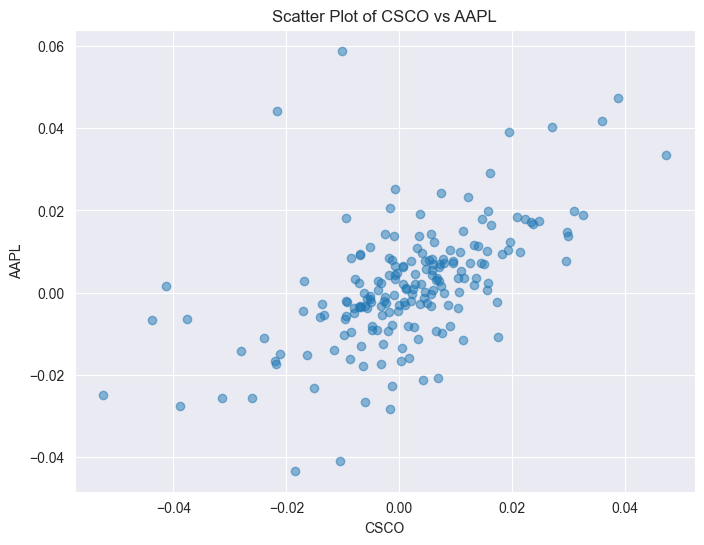

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'V')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of V vs AAPL')

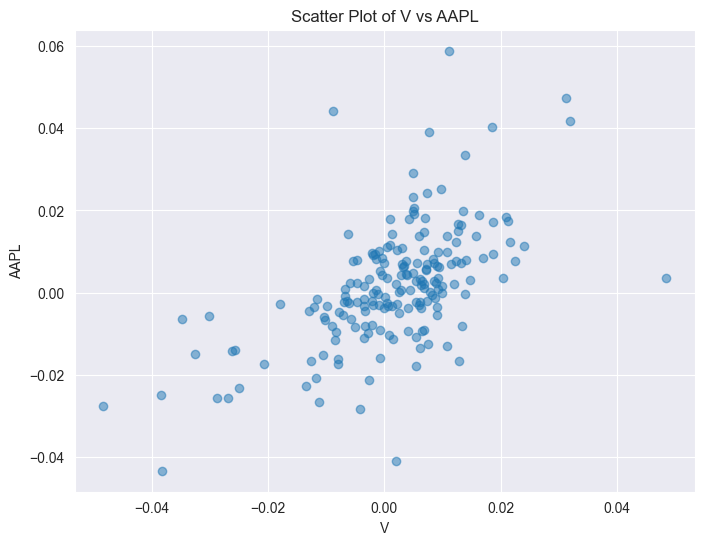

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'ADBE')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of ADBE vs AAPL')

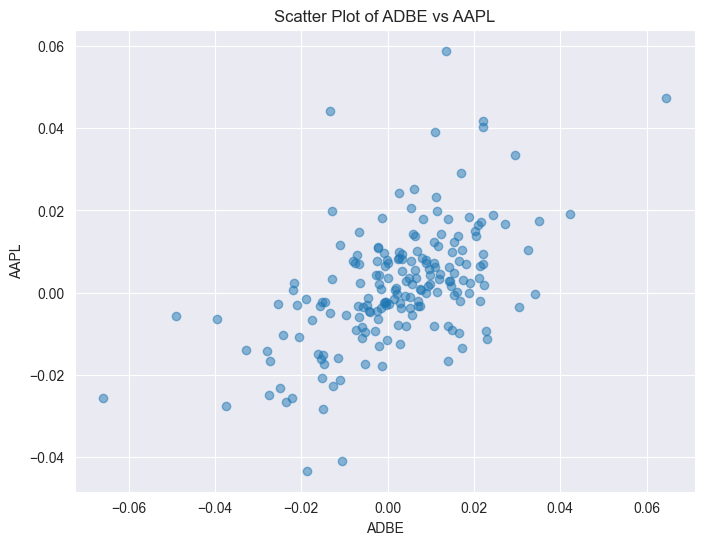

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLE')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLE vs AAPL')

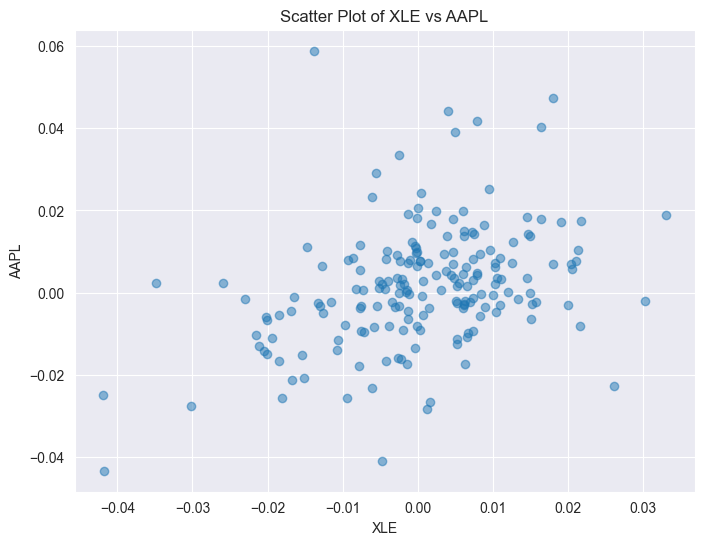

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'INTC')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of INTC vs AAPL')

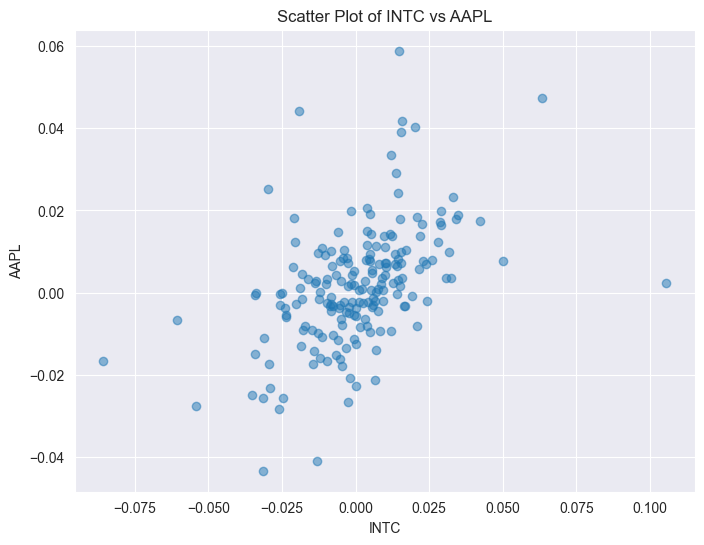

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLF')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLF vs AAPL')

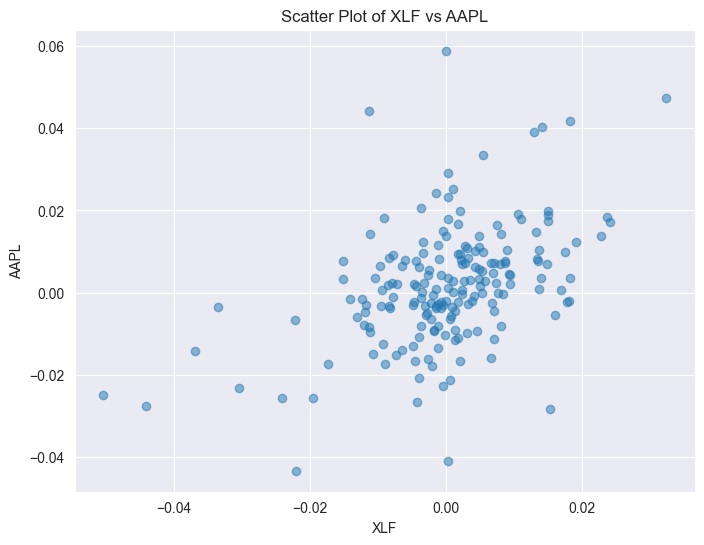

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLP')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLP vs AAPL')

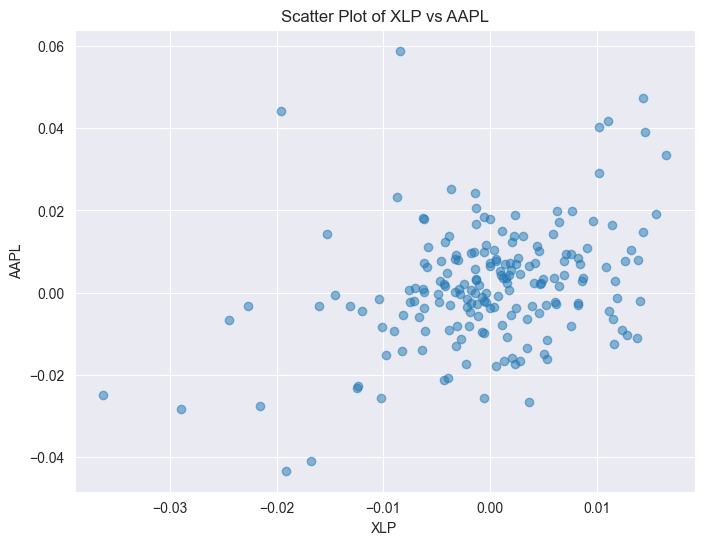

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'MSFT')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of MSFT vs AAPL')

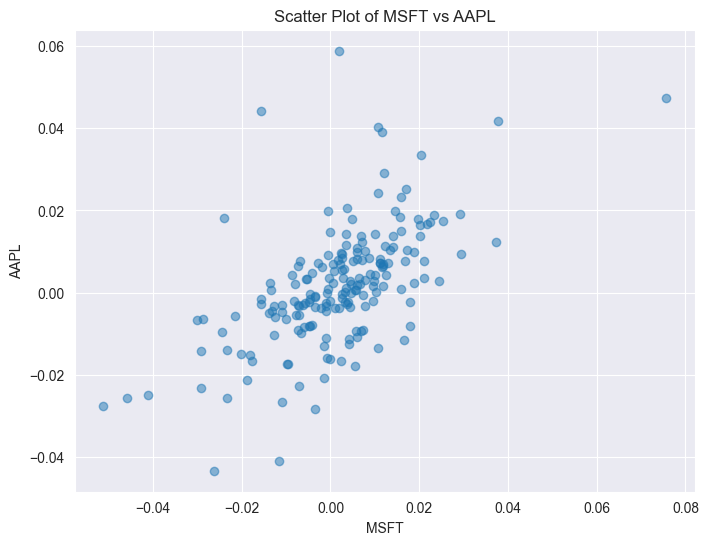

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'ACN')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of ACN vs AAPL')

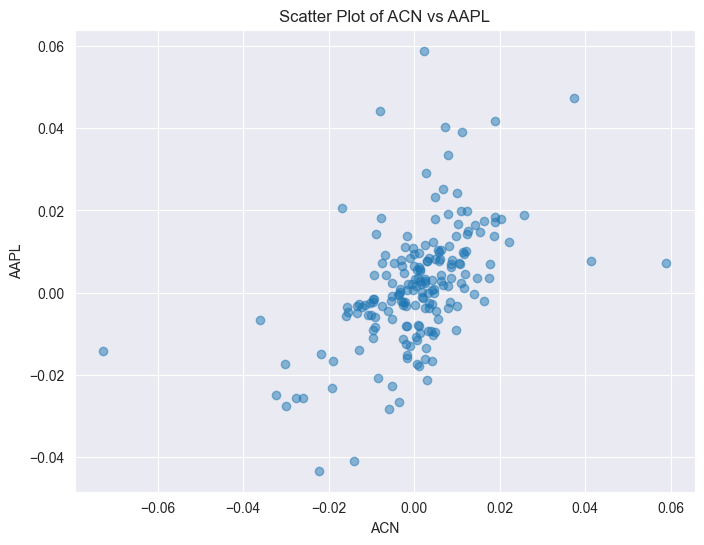

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLB')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLB vs AAPL')

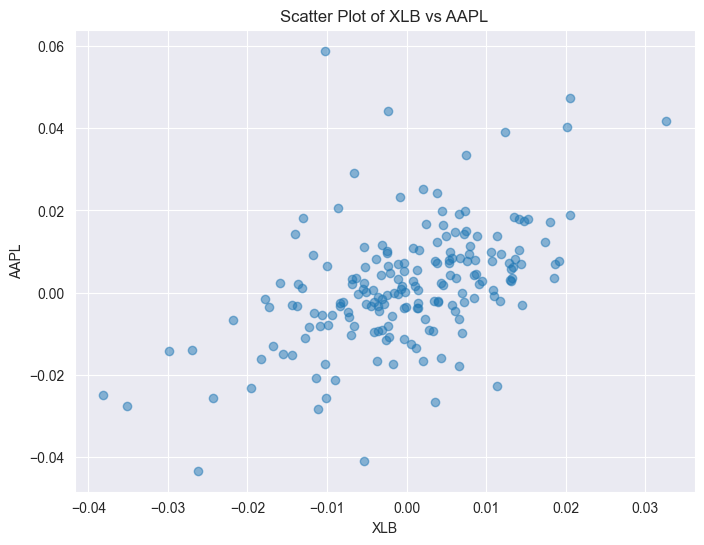

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLU')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLU vs AAPL')

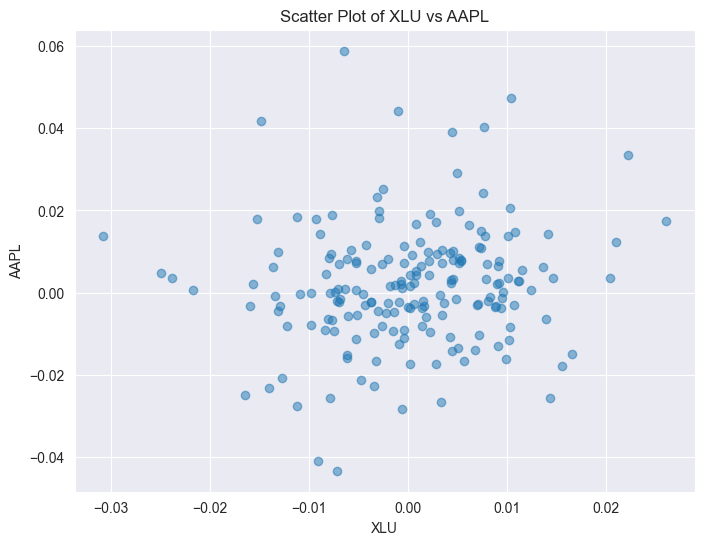

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'NVDA')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of NVDA vs AAPL')

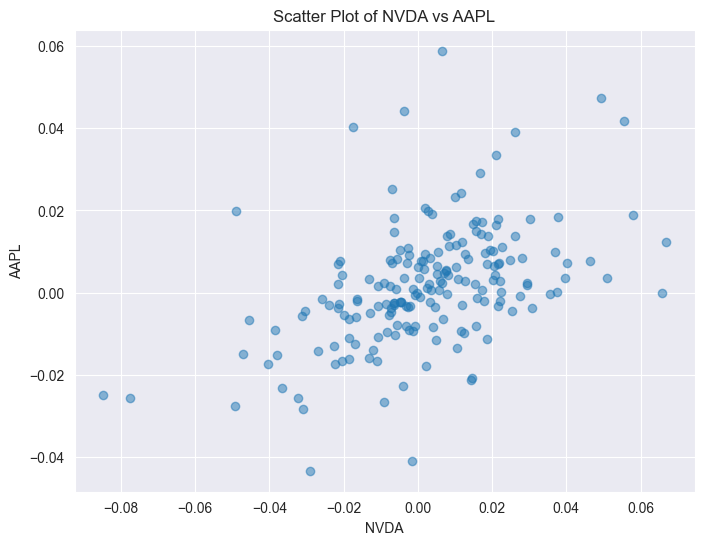

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLV')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLV vs AAPL')

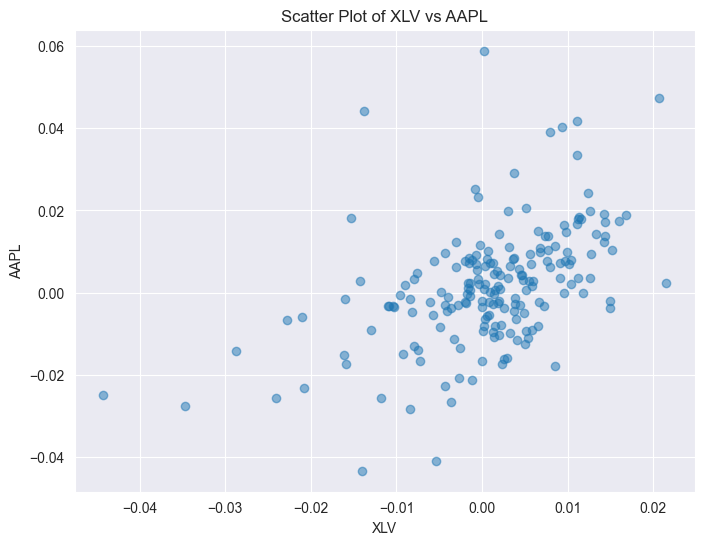

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'FB')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of FB vs AAPL')

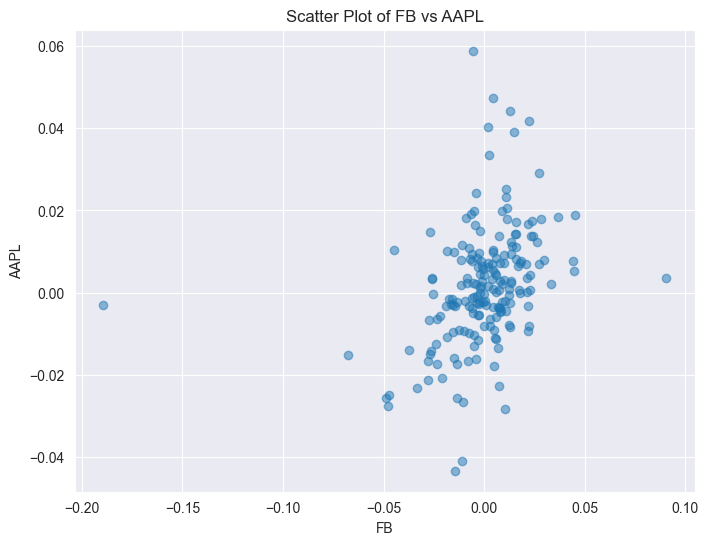

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'IBM')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of IBM vs AAPL')

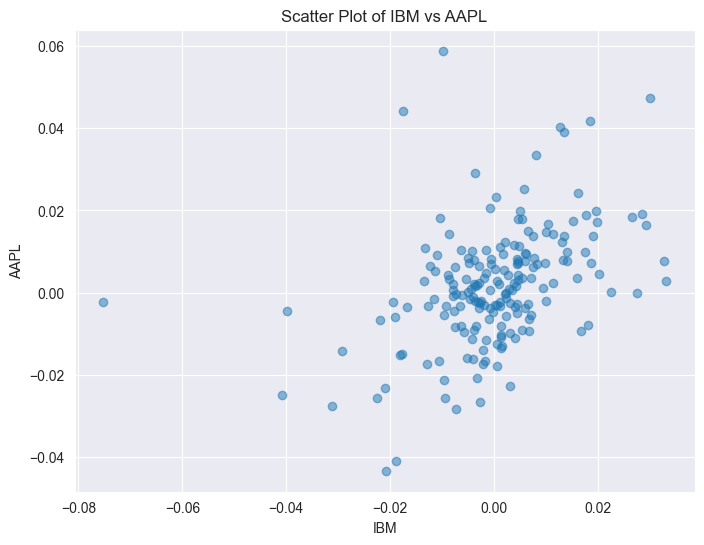

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLY')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLY vs AAPL')

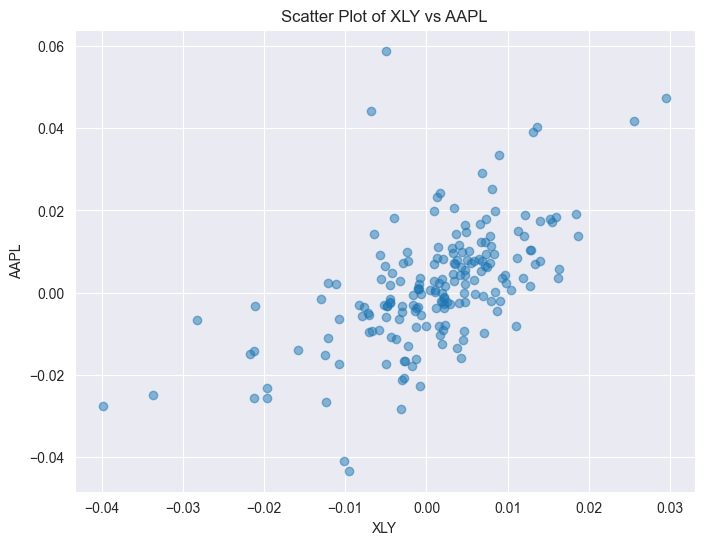

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLK')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLK vs AAPL')

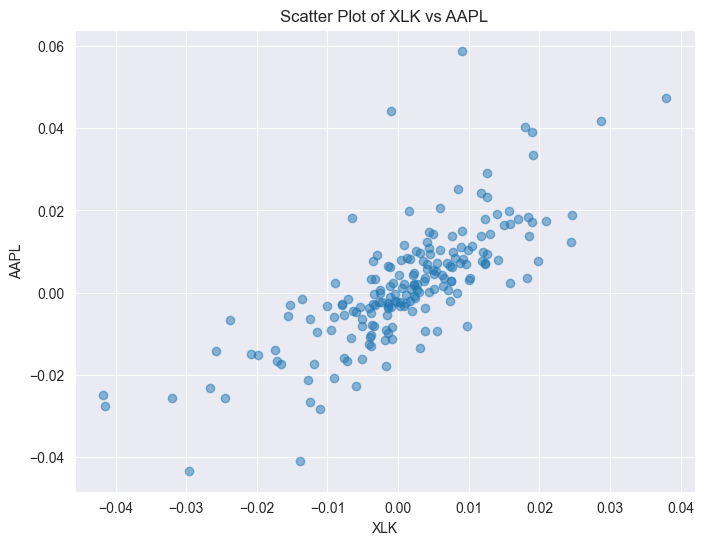

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'SPY')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of SPY vs AAPL')

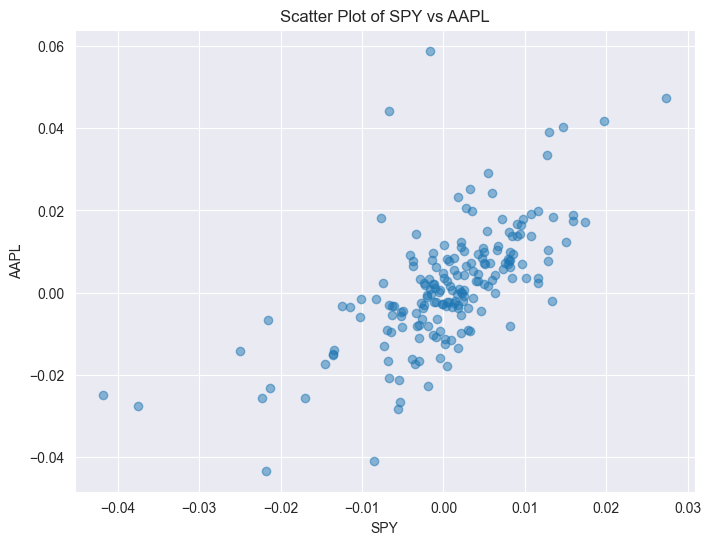

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLI')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLI vs AAPL')

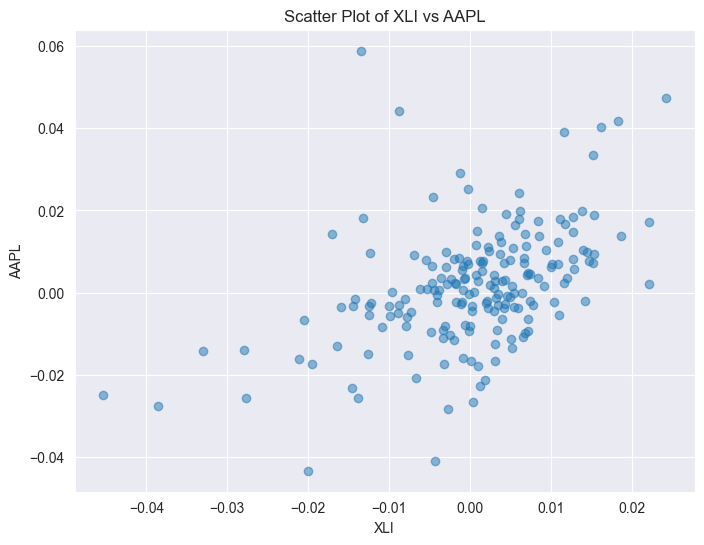

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'GOOG')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of GOOG vs AAPL')

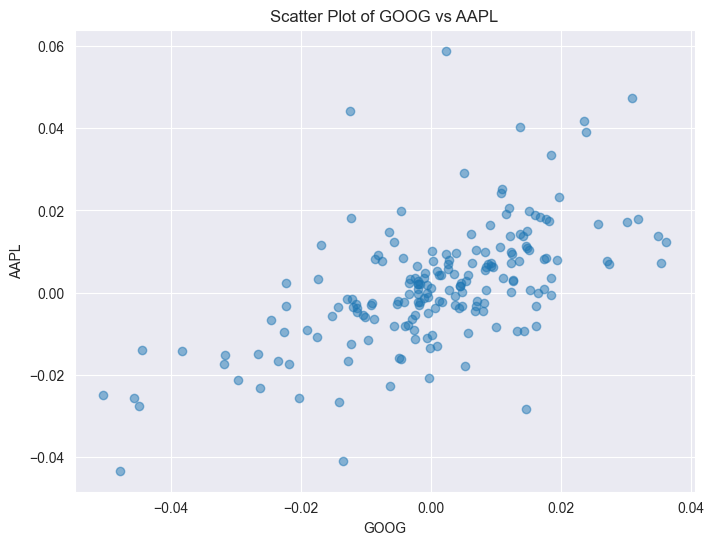

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'XLRE')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of XLRE vs AAPL')

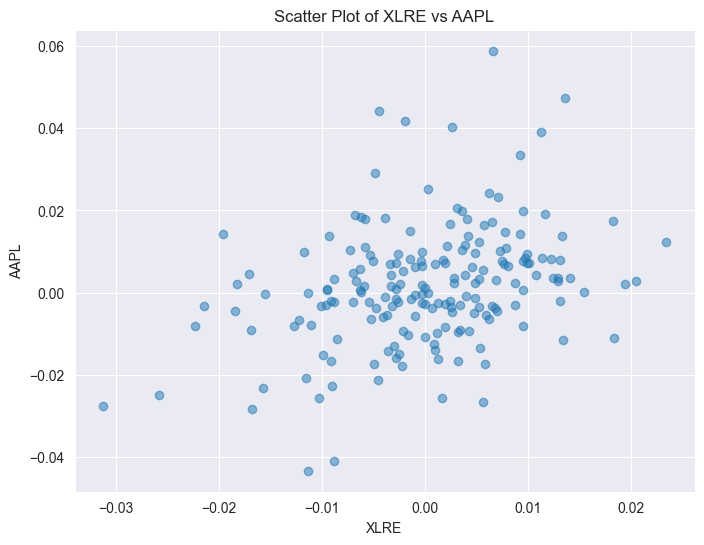

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'MA')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of MA vs AAPL')

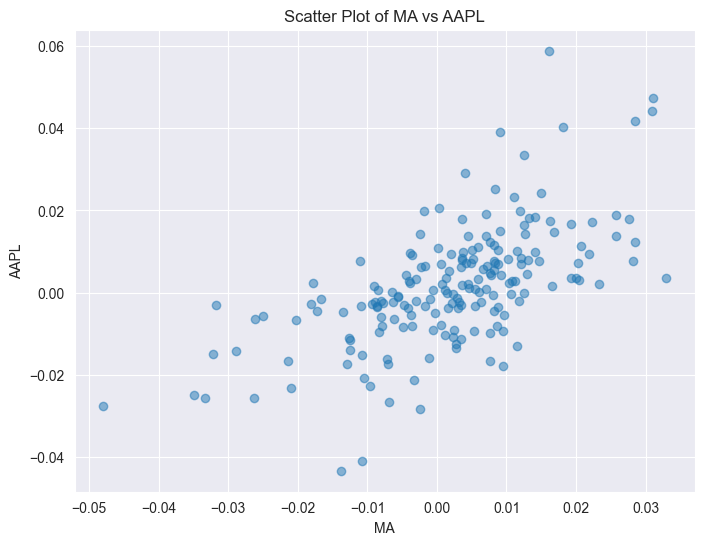

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'CRM')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, 'Scatter Plot of CRM vs AAPL')

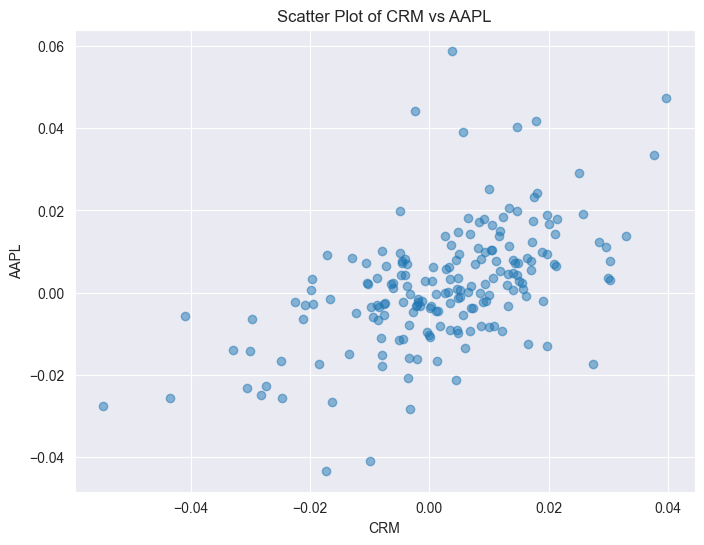

In [87]:
for column in train_combined_data_ret.columns:
    if column != 'AAPL':
        plt.figure(figsize=(8, 6))  
        plt.scatter(train_combined_data_ret[column], train_combined_data_ret['AAPL'], alpha=0.5)
        plt.xlabel(column)  
        plt.ylabel('AAPL')  
        plt.title(f'Scatter Plot of {column} vs AAPL')
        plt.show()  

No obvious nolinear relationship are found in the scatter plots. So we do not add nonlinear terms to features.
 

Next, we will visualize the linear relationships between the features and AAPL using a heatmap. This will allow us to quantitatively assess these relationships and select the most relevant features for modeling.

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

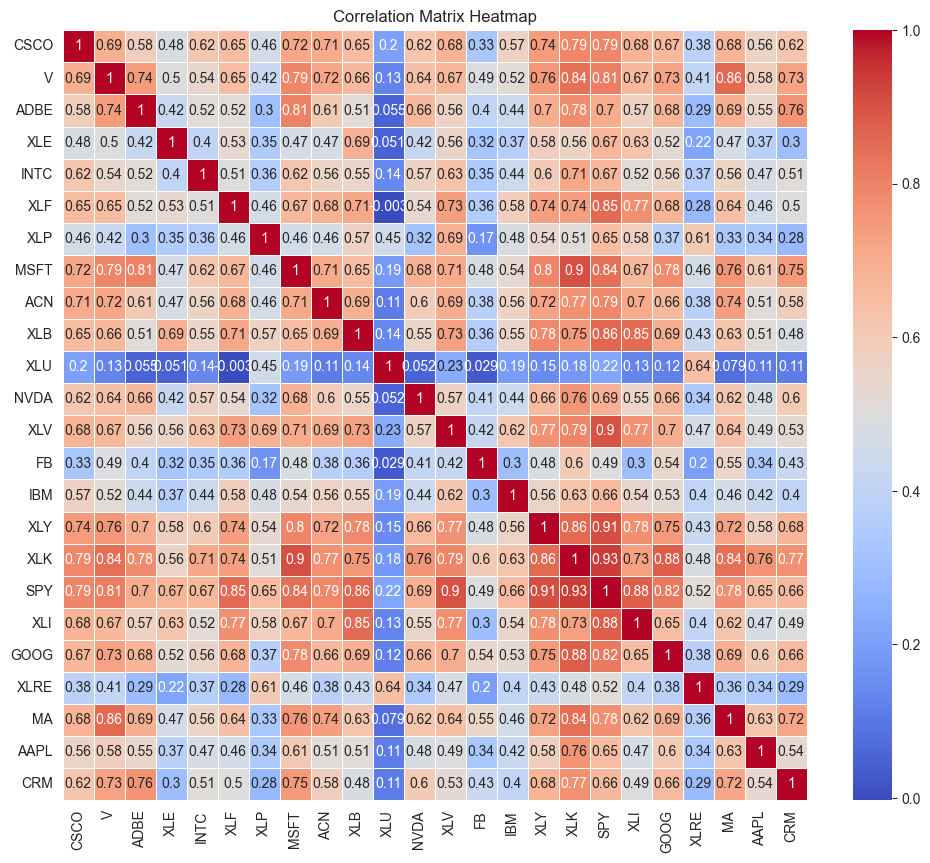

In [88]:
correlation_matrix = train_combined_data_ret.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

We analyze the correlation coefficients between the returns of different stocks or indices. If securities have a correlation coefficient higher than 0.6 with AAPL, we will include one of them. 

In [89]:
high_corr_features = correlation_matrix.index[correlation_matrix['AAPL'] > 0.6].tolist()

high_corr_features.remove('AAPL')

print("Features highly correlated with AAPL:", high_corr_features)

Features highly correlated with AAPL: ['MSFT', 'XLK', 'SPY', 'MA']


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Filtered Heatmap of Highly Correlated Features with AAPL')

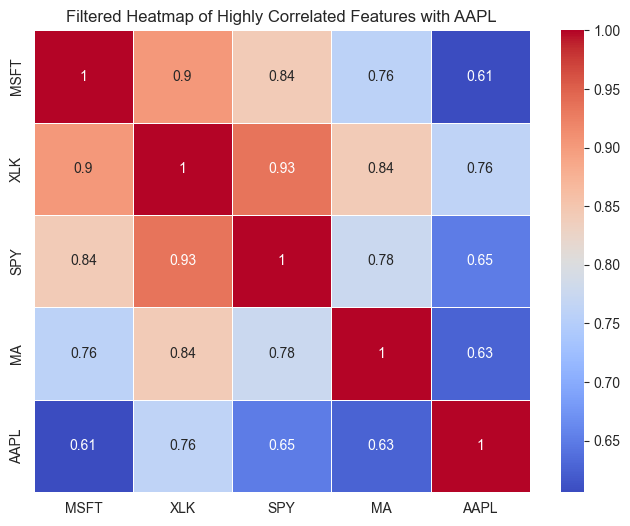

In [90]:

filtered_data = train_combined_data_ret[high_corr_features + ['AAPL']]

filtered_corr_matrix = filtered_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Heatmap of Highly Correlated Features with AAPL')
plt.show()


We will analyze the correlation coefficients between the returns of different stocks or indices. If any securities have a correlation coefficient higher than 0.85, we will exclude one of them. In this case, preference will be given to keeping the stock or index with a stronger correlation to AAPL. This approach ensures that we retain the most relevant features while minimizing multicollinearity. Therefore, we select MA,XLK as additional features.

In [91]:
train_combined_data_ret_ = train_combined_data_ret[['XLK', 'MA', 'AAPL']]

In [92]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'
test_combined_data_price = getRange(combined_data, test_start_dt, test_end_dt)
test_combined_data_price_= test_combined_data_price[['XLK', 'MA', 'AAPL']]
print(test_combined_data_price.head())
print(test_combined_data_price.tail())

               CSCO         V    ADBE      XLE     INTC      XLF      XLP  \
Dt                                                                          
2018-09-28  46.9955  149.1151  269.95  73.1120  45.8504  26.9940  52.4375   
2018-10-01  47.2080  149.8106  275.49  74.1256  45.0360  27.1017  52.3986   
2018-10-02  47.3433  148.6979  272.00  74.2028  46.6357  27.1017  52.7001   
2018-10-03  47.4689  148.3998  270.51  74.8013  47.2756  27.3562  52.1361   
2018-10-04  47.0507  145.8067  263.71  74.4924  46.6648  27.5421  52.0097   

                MSFT       ACN      XLB  ...       IBM       XLY      XLK  \
Dt                                       ...                                
2018-09-28  112.6006  166.5574  56.6824  ...  142.4749  115.5820  74.2683   
2018-10-01  113.8214  169.7966  57.2499  ...  144.1615  115.2271  74.6232   
2018-10-02  113.3686  169.4443  57.4945  ...  144.8681  113.6691  74.6331   
2018-10-03  113.3882  170.4131  57.0836  ...  144.3687  113.2846  74.8598  

In [93]:
test_combined_data_ret_ = getReturns(test_combined_data_price_)
test_combined_data_ret=getReturns(test_combined_data_price)

In [94]:
X_train= train_combined_data_ret_.drop(columns=['AAPL'])
y_train = train_combined_data_ret_[['AAPL']]
regr = createModel()
beta_0, beta_SPY = regress(regr, X_train, y_train)
print("Intercept:",beta_0)
for i in range(len(X_train.columns)):
    print(X_train.columns[i],":",beta_SPY[i])


Intercept: 0.0008156687083984941
XLK : 1.0195212966418221
MA : -0.058499070038763375


In [95]:
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("Avg cross val score = {sc:3.2f}".format(sc=cross_val_avg) )

Avg cross val score = 0.47


In [96]:
X_test = test_combined_data_ret_.drop(columns=['AAPL'])
y_test = test_combined_data_ret_[['AAPL']]
predicted_in_sample = regr.predict(X_train.values)
predicted_out_sample = regr.predict(X_test.values)

In [97]:
rmse_in_sample = computeRMSE(y_train, predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, predicted_out_sample)
print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

In Sample Root Mean squared error: 0.009
Out of Sample Root Mean squared error: 0.011


Conclusion: In this part, we use new features MA and XLK to train the model. The model has a lower RMSE in the out-of-sample data than the model with only one feature. This indicates that the new features are useful for predicting the return of AAPL.

-------------------------------------------------My Homework Ends Here--------------------------------------------

Extra Part: Feature Engineering
In this part, we will use the OpenFE package to perform feature engineering. We will use the OpenFE package to generate new features from the existing features. We will then train a model using the new features and evaluate its performance. 

In [100]:
import pandas as pd
from openfe import OpenFE, tree_to_formula
from sklearn.metrics import mean_squared_error
ofe = OpenFE()
ofe.fit(data=train_combined_data_ret.drop(columns=['AAPL']), label=y_train, n_jobs=1)
ofe.new_features_list

The number of candidate features is 1702
Start stage I selection.


  0%|          | 0/4 [00:00<?, ?it/s]/Users/yukeli/PycharmProjects/ML HW 1/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins

 25%|██▌       | 1/4 [00:05<00:16,  5.51s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training 

/Users/yukeli/PycharmProjects/ML HW 1/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training 

 50%|█████     | 2/4 [00:06<00:05,  2.87s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training 

/Users/yukeli/PycharmProjects/ML HW 1/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training 

 75%|███████▌  | 3/4 [00:07<00:02,  2.01s/it]/Users/yukeli/PycharmProjects/ML HW 1/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no mean

100%|██████████| 4/4 [00:08<00:00,  2.11s/it]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 18, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] There are no mean

1701 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/1 [00:00<?, ?it/s]/Users/yukeli/PycharmProjects/ML HW 1/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
The number of remaining candidate features is 1
Start stage II selection.


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [110]:
for feature in ofe.new_features_list:
        print(tree_to_formula(feature))

(XLE-XLF)


we find one new feature: XLE-XLF using OpenFE. We will use this new feature to train the model and evaluate its performance.

In [105]:
train_combined_data_ret["new_feature"]=train_combined_data_ret["XLE"]-train_combined_data_ret["XLF"]
test_combined_data_ret["new_feature"]=test_combined_data_ret["XLE"]-test_combined_data_ret["XLF"]
train_combined_data_ret__=train_combined_data_ret[['XLK', 'MA', 'AAPL','new_feature']]
test_combined_data_ret__=test_combined_data_ret[['XLK', 'MA', 'AAPL','new_feature']]

In [106]:
X_train= train_combined_data_ret__.drop(columns=['AAPL'])
y_train = train_combined_data_ret__[['AAPL']]
regr = createModel()
beta_0, beta_SPY = regress(regr, X_train, y_train)
print("Intercept:",beta_0)
for i in range(len(X_train.columns)):
    print(X_train.columns[i],":",beta_SPY[i])

Intercept: 0.0007787105797813896
XLK : 1.0241958094618953
MA : -0.05455293036621543
new_feature : 0.06465383072250885


In [107]:
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("Avg cross val score = {sc:3.2f}".format(sc=cross_val_avg) )

Avg cross val score = 0.47


In [108]:
X_test = test_combined_data_ret__.drop(columns=['AAPL'])
y_test = test_combined_data_ret__[['AAPL']]
predicted_in_sample = regr.predict(X_train.values)
predicted_out_sample = regr.predict(X_test.values)

In [109]:
rmse_in_sample = computeRMSE(y_train, predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, predicted_out_sample)
print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

In Sample Root Mean squared error: 0.009
Out of Sample Root Mean squared error: 0.011


Conclusion: In this part, we use the new feature XLE-XLF generated by OpenFE to train the model. The model has same RMSE in the out-of-sample data than the model with only two features. This indicates that the new feature is not that useful for predicting the return of AAPL. This could also be seen from beta conefficient of the new feature, which is close 0 and very small compare to the coefficient of XLK.